In [111]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.io
from scipy.io import savemat
import os
from scipy.signal import find_peaks



### Realistic Channel Models**

Simulate more realistic environments:

* **Multipath fading**: Add Rayleigh or Rician fading (`scipy.signal.convolve` or tap delay line).
* **Doppler spread**: For mobile scenarios, apply time-varying channel impulse responses.
* **Frequency offset & phase noise**: Model oscillator mismatch and jitter.
* **Timing offset & jitter**: Add sample delays and timing estimation error.

---

### Synchronization Mechanisms**

Real receivers always implement:

* **Timing synchronization** (e.g., using cyclic prefix autocorrelation or Schmidl-Cox algorithm).
* **Frequency offset correction**.
* **Frame detection** (using preamble sequences like Zadoff-Chu or PN sequences).

---

### Channel Estimation & Equalization**

Instead of assuming perfect channel knowledge:

* Insert **pilot symbols** or use **training sequences**.
* Implement **LS (Least Squares)** or **MMSE equalization**.
* Plot **channel frequency response** and estimate SNR per subcarrier.

---

### Performance Metrics & Visualization**

* BER vs. SNR (you’re doing this already).
* **EVM (Error Vector Magnitude)**.
* **Constellation diagram before/after equalization**.
* **Spectrogram or PSD of transmitted signal**.

---



### Add Forward Error Correction (FEC)**

Industry systems always use FEC:

* Add **convolutional coding** (with `commpy`), **LDPC**, or **Turbo codes**.
* Use **soft-decision decoding** and integrate with BER evaluation.

---

### Hardware-Aware Constraints**

* Quantization: Add ADC/DAC effects (bit depth).
* Clipping & PAPR: Add non-linearities and evaluate Peak-to-Average Power Ratio (PAPR).
* Power normalization across symbols.

---

### Export to SDR / Real-Time**

If you want to push further:

* Generate `.wav` files or IQ samples for use in **GNU Radio**, **SDR hardware**, or **Simulink**.
* Use `pyserial` or `SoapySDR` if moving toward embedded/hardware.

---

### Example Goal:

> **End-to-End OFDM Tx/Rx with multipath fading, synchronization, pilot-aided channel estimation, FEC, and BER vs. SNR analysis — all modular and ready for SDR testing.**



# TX + Channel 

In [112]:
class OFDM_TX_plus_channel: 
    def __init__(self,ifft_size,cp_length,num_symbols,mod_order,num_active):
        self.ifft_size = ifft_size
        self.cp_length = cp_length
        self.num_symbols = num_symbols
        self.mod_order = mod_order
        self.num_active = num_active 

    def OFDM_Tx(self):
        Ld = self.ifft_size
        Ls = Ld + self.cp_length 
        dc_index = self.ifft_size // 2 
        half = self.num_active // 2
        active_subcarriers = list(range(dc_index - half, dc_index)) + \
                            list(range(dc_index + 1, dc_index + half + 1))
        return dc_index, active_subcarriers

    def generate_mqam_symbols(self):
        bits_per_symbol = int(np.log2(self.mod_order))
        total_bits = self.num_active * self.num_symbols * bits_per_symbol
        bits = np.random.randint(0,2,total_bits) 
        symbol_bin = bits.reshape(-1,bits_per_symbol) 
        bits_per_axis = bits_per_symbol // 2 
        M_axis = int(np.sqrt(self.mod_order)) 
        bits_I = symbol_bin[:, :bits_per_axis] 
        bits_Q = symbol_bin[:, bits_per_axis:] 
        def bin2dec(arr): 
            return arr.dot(1 << np.arange(arr.shape[-1]-1,-1,-1))
        I_indices = bin2dec(bits_I)
        Q_indices = bin2dec(bits_Q) 
        I_vals = 2*I_indices - (M_axis - 1)
        Q_vals = 2*Q_indices - (M_axis - 1)
        qam_data = I_vals + 1j*Q_vals 
        qam_data /= np.sqrt(np.mean(np.abs(qam_data)**2))

        return qam_data, bits 

    def generate_ofdm_signal(self, qam_data, active_subcarriers, dc_index):
        self.num_active = len(active_subcarriers)
        symbol_matrix = np.zeros((self.num_symbols, self.ifft_size), dtype=complex)
        ofdm_signal = []

        for i in range(self.num_symbols):
            idx_start = i * self.num_active
            idx_end = (i + 1) * self.num_active
            this_symbol = qam_data[idx_start:idx_end]
            freq_data = np.zeros(self.ifft_size, dtype=complex)
            freq_data[active_subcarriers] = this_symbol
            freq_data[dc_index] = 0  # Null DC
            time_data = np.fft.ifft(freq_data) * np.sqrt(self.ifft_size)
            symbol_matrix[i, :] = freq_data
            cp = time_data[-self.cp_length:]
            ofdm_symbol = np.concatenate((cp, time_data))
            ofdm_signal.append(ofdm_symbol)

        ofdm_signal = np.concatenate(ofdm_signal)
        ofdm_signal /= np.sqrt(np.mean(np.abs(ofdm_signal) ** 2))

        return ofdm_signal, symbol_matrix

    def add_noise_and_pad(self,ofdm_signal, noise_snr_db, left_pad, right_pad, save_path='OFDM_Rx_Signal.mat'):
        signal_power = np.mean(np.abs(ofdm_signal)**2)
        noise_power = signal_power / (10**(noise_snr_db / 10))
        noise_std = np.sqrt(noise_power / 2)
        inband_noise = noise_std * (np.random.randn(len(ofdm_signal)) + 1j * np.random.randn(len(ofdm_signal)))
        ofdm_signal_noisy = ofdm_signal + inband_noise
        noise_before = noise_std * (np.random.randn(left_pad) + 1j * np.random.randn(left_pad))
        noise_after  = noise_std * (np.random.randn(right_pad) + 1j * np.random.randn(right_pad))
        final_signal = np.concatenate([noise_before, ofdm_signal_noisy, noise_after])
        savemat(save_path, {'final_signal': final_signal})

        return final_signal

    def ofdm_demodulate(self,ofdm_signal_noisy, ifft_size, cp_length):
        Ld = ifft_size
        Ls = Ld + cp_length
        num_symbols_actual = len(ofdm_signal_noisy) // Ls
        X_matrix = ofdm_signal_noisy[:num_symbols_actual * Ls].reshape((num_symbols_actual, Ls))
        X_no_cp = X_matrix[:, cp_length:] 
        X_fft = np.fft.fft(X_no_cp, axis=1)
        power_matrix = np.abs(X_fft) ** 2  
        full_power = np.zeros((num_symbols_actual, ifft_size))
        full_power[:, :Ld] = power_matrix

        return full_power, X_fft, power_matrix

    def plot_subcarrier_power(self,power_matrix, ifft_size, num_symbols_actual):
        power_db = 10 * np.log10(power_matrix + 1e-12)  # avoid log(0)
        plt.figure(figsize=(12, 5))
        extent = [0, num_symbols_actual, 0, ifft_size]
        im = plt.imshow(
            power_db.T,
            aspect='auto',
            extent=extent,
            origin='lower',
            cmap='jet',
            vmin=np.max(power_db) - 40,
            vmax=np.max(power_db)
        )
        plt.title('Subcarrier Power Spectrum (dB)', fontsize=14)
        plt.xlabel('OFDM Symbol Index', fontsize=12)
        plt.ylabel('Subcarrier Index', fontsize=12)
        plt.colorbar(im, label='Power (dB)')
        plt.grid(False)
        plt.tight_layout()
        plt.show()
    
    def plot_autocorrelation(self,signal, max_lag=None):
        N = len(signal)
        if max_lag is None:
            max_lag = N // 2
        corr = np.correlate(signal, signal, mode='full') 
        lags = np.arange(-N + 1, N)
        corr = corr / np.max(np.abs(corr)) 
        positive_lags = lags >= 0
        lags_positive = lags[positive_lags][:max_lag]
        Rxx_positive = corr[positive_lags][:max_lag]
        plt.figure(figsize=(10, 4))
        plt.plot(lags_positive, np.abs(Rxx_positive))
        plt.title('Autocorrelation of the Received Signal')
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation Coefficient')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_psd(self,power_matrix, ifft_size, fs=1.0):
        avg_power = np.mean(power_matrix, axis=0)
        psd_shifted = np.fft.fftshift(avg_power) / (fs / ifft_size)
        psd_db = 10 * np.log10(psd_shifted + 1e-12)
        if ifft_size % 2 == 0:
            freq_axis = np.linspace(-fs/2, fs/2, ifft_size, endpoint=False)
        else:
            freq_axis = np.linspace(-fs/2, fs/2, ifft_size)
        plt.figure(figsize=(10, 4))
        plt.plot(freq_axis, psd_db, linewidth=1.2)
        plt.title('Power Spectral Density (dB/Hz)')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD (dB/Hz)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_constellation(self,X_fft, active_subcarriers):
        rx_constellation = X_fft[:, active_subcarriers] 
        rx_symbols_flat = rx_constellation.flatten()
        avg_power = np.mean(np.abs(rx_symbols_flat)**2)
        scale = 2 * np.sqrt(avg_power)
        plt.figure(figsize=(6, 6))
        plt.scatter(rx_symbols_flat.real, rx_symbols_flat.imag, s=10, c='blue', alpha=0.6)
        plt.title('QPSK Constellation after OFDM Demodulation')
        plt.xlabel('In-phase')
        plt.ylabel('Quadrature')
        plt.grid(True)
        plt.axis('equal')
        plt.xlim([-scale, scale])
        plt.ylim([-scale, scale])
        plt.tight_layout()
        plt.show()

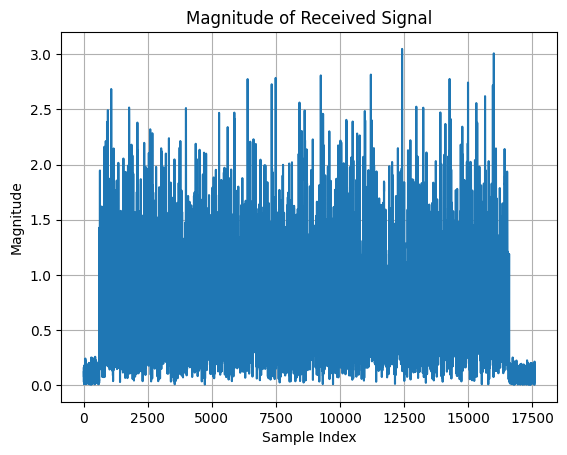

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


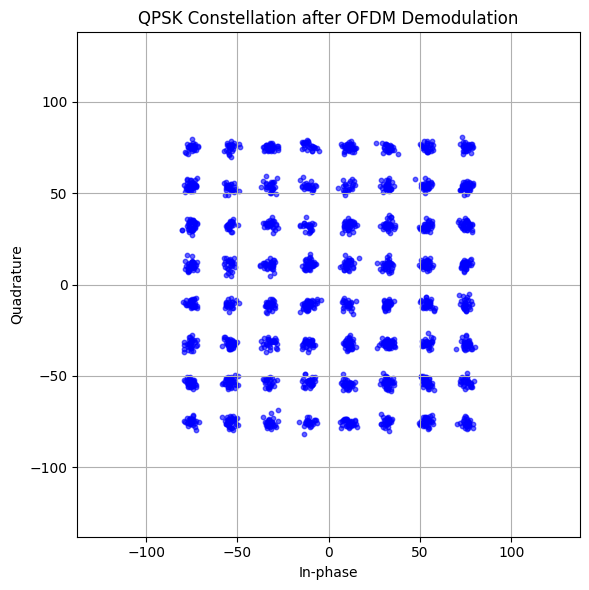

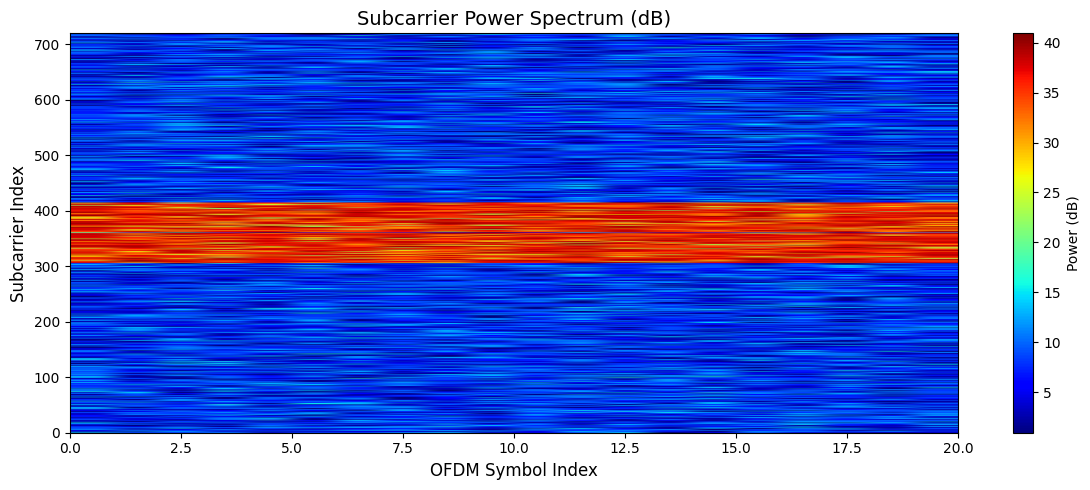

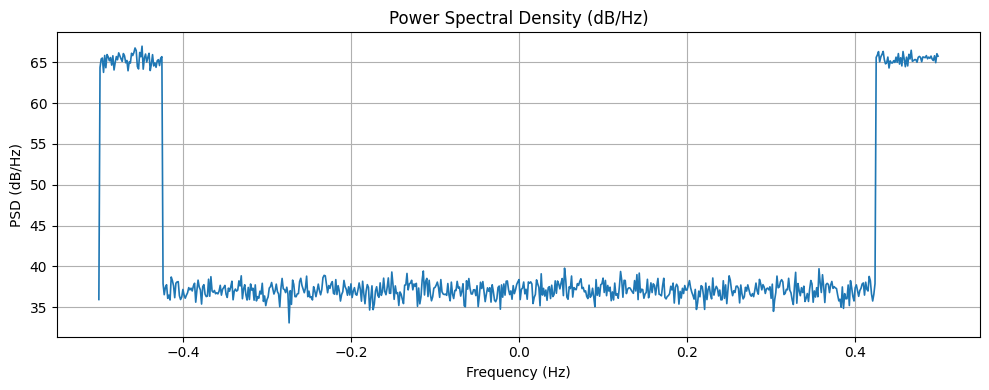

In [113]:
ifft_size = 720
cp_length = 80
num_symbols = 20
mod_order = 64
num_active = 109
snr_db = 20
left_pad = 600
right_pad = 1000

# Step 1: Instantiate the class
ofdm = OFDM_TX_plus_channel(ifft_size, cp_length, num_symbols, mod_order, num_active)
# Step 2: Get active subcarriers and DC index
dc_index, active_subcarriers = ofdm.OFDM_Tx()
# Step 3: Generate QAM symbols and bits
qam_data, tx_bits = ofdm.generate_mqam_symbols()
# Step 4: Generate OFDM signal
ofdm_signal, symbol_matrix = ofdm.generate_ofdm_signal(qam_data, active_subcarriers, dc_index)
# Step 5: Add noise and padding
rx_signal = ofdm.add_noise_and_pad(ofdm_signal, snr_db, left_pad, right_pad)
# Step 6: Demodulate OFDM signal (remove padding first)
rx_no_pad = rx_signal[left_pad: -right_pad]
power_matrix, X_fft, _ = ofdm.ofdm_demodulate(rx_no_pad, ifft_size, cp_length)


plt.figure()
plt.plot(np.abs(rx_signal))  # Magnitude
plt.title('Magnitude of Received Signal')
plt.xlabel('Sample Index')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()
# Plot constellation 
ofdm.plot_constellation(X_fft, active_subcarriers)
# Plot subcarrier power 
ofdm.plot_subcarrier_power(power_matrix, ifft_size, num_symbols)
ofdm.plot_psd(power_matrix, ifft_size, fs=1.0)



# Receiver 

In [114]:
# Load the received signal
Received = scipy.io.loadmat('OFDM_Rx_Signal.mat')
print(Received.keys())
rx_signal = Received['final_signal']  
rx_signal = rx_signal.squeeze()  

dict_keys(['__header__', '__version__', '__globals__', 'final_signal'])


In [115]:
class OFDM_RX: 
    def __init__(self, rx_signal):
        self.rx_signal = rx_signal
    
    def signal_preprocessing(self,initial_start,threshold_start): 
        plt.figure()
        plt.plot(np.abs(self.rx_signal))  # Magnitude
        plt.title('Magnitude of Received Signal')
        plt.xlabel('Sample Index')
        plt.ylabel('Magnitude')
        plt.grid(True)
        plt.show()

        plt.figure()
        plt.plot(np.abs(self.rx_signal)**2)  # Magnitude
        plt.xlabel('Sample Index')
        plt.ylabel('Magnitude^2')
        plt.grid(True)
        plt.show()

        noise1_power = np.mean(np.abs(rx_signal[:initial_start])**2) 

        # Find the start index where signal power exceeds noise threshold
        ind = np.where(np.abs(rx_signal)**2 > threshold_start * noise1_power)[0]
        start_index = ind[0] if len(ind) > 0 else None

        # Plot up to 5×start_index
        plt.figure(figsize=(10, 4))
        plt.plot(np.abs(rx_signal[:5*start_index]), label='|Received|')
        plt.axvline(start_index - 100, color='r', linestyle='--')
        plt.axvline(start_index + 100, color='r', linestyle='--')

        # Shade the region from (start_index - 100) to (start_index + 100)
        x_shade = [start_index - 100, start_index + 100, start_index + 100, start_index - 100]
        y_shade = [0, 0, 3, 3]  # Adjust height if needed based on your signal

        plt.fill(x_shade, y_shade, color='red', alpha=0.3, label='Detection Window')
        plt.title("Start Index Detection")
        plt.xlabel("Sample Index")
        plt.ylabel("Magnitude")
        plt.grid(True)
        plt.legend()
        plt.show()
        print("Start Index of Signal:", start_index)
        return start_index 
    

    def detect_end_index(self, noise_est_start, threshold_end, plot=True):
        # Estimate noise power from the known tail region
        noise_power = np.mean(np.abs(self.rx_signal[noise_est_start:])**2)
        threshold = threshold_end * noise_power
        power = np.abs(self.rx_signal)**2

        # Set where to start scanning for stop index (e.g., after halfway point)
        search_start = noise_est_start  # or dynamic: len(rx_signal) // 2
        window_len = 300

        stop_index = None
        for i in range(search_start, len(self.rx_signal) - window_len):
            window = power[i:i+window_len]
            if np.all(window < threshold):
                stop_index = i
                break
        if plot:
            plt.figure(figsize=(8, 4))
            plt.plot(np.abs(self.rx_signal), label='|Received Signal|')
            if stop_index:
                plt.axvline(stop_index, color='r', linestyle='--', label=f'Stop Index = {stop_index}')
            plt.axvspan(noise_est_start, len(self.rx_signal), color='red', alpha=0.3, label='Noise Estimation Region')
            plt.title('End-of-Signal Detection')
            plt.xlabel('Sample Index')
            plt.ylabel('Magnitude')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()
            print("Stop Index:", stop_index)

        return stop_index


    def autocorrelation(self,start_index,height):
        rx_clean = self.rx_signal[start_index:]  # Remove noise before OFDM signal
        N = len(rx_clean)
        max_lag = N // 2
        Rxx_full = np.correlate(rx_clean, rx_clean, mode='full')
        lags = np.arange(-N + 1, N)
        Rxx_full = Rxx_full / np.max(np.abs(Rxx_full))  # Normalize
        mid_index = len(Rxx_full) // 2
        Rxx_positive = Rxx_full[mid_index:(mid_index + max_lag + 1)]
        lags_positive = lags[mid_index:(mid_index + max_lag + 1)]

        plt.figure(figsize=(10, 4))
        plt.plot(lags_positive, np.abs(Rxx_positive))
        plt.title('Autocorrelation of Clean Received Signal')
        plt.xlabel('Lag (samples)')
        plt.ylabel('Normalized Autocorrelation')
        plt.grid(True)
        plt.show()
        peaks, _ = find_peaks(np.abs(Rxx_positive), height, distance=300)
        peak_lags = lags_positive[peaks]
        print("Detected peak lags:", peak_lags)
        if len(peak_lags) >= 2:
            diffs = np.diff(peak_lags)
            # symbol_duration_est = int(np.median(diffs))
            symbol_duration_est = peak_lags[1]
            print("Estimated Symbol Duration:", symbol_duration_est, "samples")
        else:
            print("Not enough peaks found to estimate symbol duration.")
            
        return symbol_duration_est
    

    def CP_detection(self,start_index,symbol_duration_est):
        Ld = symbol_duration_est
        mm = [] # maximum metric for CP
        search_range = range(start_index - 100, start_index + 100)

        # Loop over potential start indices around estimated start_index
        for j in search_range:
            x = self.rx_signal[j:]
            c = np.zeros((Ld // 4, 10))  # Rows: possible CP lengths, Cols: symbols (3 to 18)

            for i in range(1, 10):  # symbol indices
                for cp_len in range(1, Ld // 4 + 1):
                    Td = cp_len + Ld
                    start = (i - 1) * Td
                    end_ = i * Td
                    if end_ > len(x):
                        continue
                    x1 = x[start:end_]
                    c[cp_len - 1, i] = np.abs(np.sum(np.conj(x1[:cp_len]) * x1[-cp_len:]))

            cp_avg = np.mean(c, axis=1)
            mm.append(np.max(cp_avg))

        j_range = list(search_range)
        mm = np.array(mm)
        plt.figure(figsize=(10, 4))
        plt.stem(j_range, mm, linefmt='C0-', markerfmt='C0o', basefmt=" ")
        plt.title("Maximum CP Correlation vs. Start Index")
        plt.xlabel("Candidate Start Index")
        plt.ylabel("Max CP Metric")
        plt.grid(True)
        plt.show()
        mm_max_idx = j_range[np.argmax(mm)]
        print(f"Maximum CP Metric = {np.max(mm):.2f} at index = {mm_max_idx}")

        x = self.rx_signal[start_index:]
        c = np.zeros((Ld // 4, 19))  # Rows: CP lengths, Cols: symbol instances 

        # Process each symbol index from 3 to 20
        for i in range(3, 20):
            for cp_length_est in range(1, Ld // 4 + 1):
                Td = cp_length_est + Ld  # Total duration of one symbol with CP
                start = (i - 1) * Td
                end_ = i * Td
                if end_ > len(x):  # Safety check
                    continue
                x1 = x[start:end_]
                a = x1[:cp_length_est]
                b = x1[-cp_length_est:]
                numer = np.sum(np.conj(a) * b)
                denom = np.sqrt(np.sum(np.abs(a)**2) * np.sum(np.abs(b)**2))
                c[cp_length_est - 1, i-1] = np.abs(numer / denom)

            plt.figure(figsize=(6, 3))
            plt.plot(c[:, i - 1])
            plt.title(f"CP Correlation for Symbol {i}")
            plt.xlabel("CP Length Estimate")
            plt.ylabel("Correlation Magnitude")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        # Average CP correlation across symbols
        cp_avg = np.mean(c[:, :20], axis=1)  # Use only columns 0–7 (symbols 1 to 8)

        # Store maximum correlation (for this fixed start_index)
        mm_val = np.max(cp_avg)
        print(f"Max averaged CP correlation: {mm_val:.4f}")
        # Find CP length corresponding to maximum average correlation

        min_cp = 4  # Avoid CP = 1–3
        search_range = np.arange(min_cp, Ld // 4 + 1)
        valid_cp_avg = cp_avg[min_cp - 1:]  # cp_avg[3:] if min_cp = 4
        cp_index = np.argmax(valid_cp_avg)
        estimated_cp_length = search_range[cp_index]
        print(f"Estimated CP Length: {estimated_cp_length} samples")
        print("Edtimated Symbol Length, Ld: ", symbol_duration_est - estimated_cp_length)
        print("Estimated Symbol Length + CP, Td: ", symbol_duration_est)

        return estimated_cp_length


    def constellation(self,estimated_cp_length,symbol_duration_est,start_index,stop_index):
        x_raw = self.rx_signal

        for k in [1]:  # You can extend to [1, 2, 4, 5, 8, 10, 16, 20, 40]
            print(f"Processing for k = {k}")
            Lcp = int(estimated_cp_length/k)
            Ld = int(symbol_duration_est/k)
            Ls = Lcp + Ld  # Total symbol length
            print(f"  Lcp = {Lcp}, Ld = {Ld}, Ls = {Ls}")
            # print("start_index :", start_index)
            # print("stop index :", stop_index)
            signal_length = stop_index - start_index; #Total samples in signal
            num_symbols = int(signal_length / Ls); # Only complete symbols
            print(f" num_symbols = {num_symbols}")
            # downsampling (optional)
            x = x_raw[::k]
            for indd in [start_index]:
                print(f"  Start index = {indd}")
                x = x_raw[indd:]
                N = len(x)
                # num_symbols = len(x) // Ls  # Fixed manually
                total_length = num_symbols * Ls
                if total_length > N:
                    print("  Not enough data to extract symbols.")
                    continue
                x_truncated = x[:total_length]
                # Reshape into symbols: shape = (Ls, num_symbols)
                x_symbols = x_truncated.reshape((Ls, num_symbols), order='F')
                # Remove CP from each symbol (result: shape = (Ld, num_symbols))
                x_no_cp = x_symbols[Lcp:, :]
                # Perform FFT on each column (along rows)
                X_symbols = np.fft.fft(x_no_cp, n=Ld, axis=0)
                # Shift frequency spectrum (zero-freq to center)
                X_symbols = np.fft.fftshift(X_symbols, axes=0)
                # Flatten to 1D vector
                constellation_points = X_symbols.flatten()
                # Plot the constellation
                plt.figure(figsize=(6, 6))
                plt.plot(np.real(constellation_points), np.imag(constellation_points), 'o', markersize=2)
                plt.title(f'Constellation (k = {k})')
                plt.xlabel('In-phase')
                plt.ylabel('Quadrature')
                plt.grid(True)
                plt.axis('equal')
                plt.show()
        
    def constellation_vs_start_index(self,start_index,symbol_duration_est,estimated_cp_length):
        Ld = symbol_duration_est
        Lcp = estimated_cp_length
        for k in [1]:
            Lcp = int(Lcp / k)  # Adjusted CP length
            Ld = int(Ld / k)  # Adjusted data (useful symbol) length
            Ls = Lcp + Ld      # Total OFDM symbol length
            print(f"\nProcessing with k={k}, Lcp={Lcp}, Ld={Ld}, Ls={Ls}")
            print(f" num_symbols = {num_symbols}")
            for indd in range(start_index-1, start_index + 3):  
                print(f"  Processing start index: {indd}")
                x = self.rx_signal[indd:]
                N = len(x)
                total_length = num_symbols * Ls
                if total_length > N:
                    print("  Skipping: Not enough data.")
                    continue
                # Truncate signal to complete symbols
                x_truncated = x[:total_length]
                # Reshape into (Ls, num_symbols) matrix
                x_symbols = x_truncated.reshape((Ls, num_symbols), order='F')
                # Remove CP from each symbol → shape (Ld, num_symbols)
                x_no_cp = x_symbols[Lcp:, :]
                # Apply FFT on each symbol (column-wise)
                X_symbols = np.fft.fft(x_no_cp, n=Ld, axis=0)
                # Shift zero-frequency to center
                X_symbols = np.fft.fftshift(X_symbols, axes=0)
                # Flatten to form 1D list of constellation points
                constellation_points = X_symbols.flatten()
                plt.figure(figsize=(6, 6))
                plt.plot(np.real(constellation_points), np.imag(constellation_points), 'o', markersize=2)
                plt.title(f'Constellation (k={k}, start={indd})')
                plt.xlabel('In-phase')
                plt.ylabel('Quadrature')
                plt.grid(True)
                plt.axis('equal')
                plt.tight_layout()
                plt.show()


    def PSD_RX(self,symbol_duration_est,estimated_cp_length,start_index):
        Lcp = estimated_cp_length
        Ld = symbol_duration_est
        Ls = Lcp + Ld
        for k in [1]:
            print(f"\nProcessing with k={k}, Lcp={Lcp}, Ld={Ld}, Ls={Ls}")
            for indd in [start_index]:
                x = self.rx_signal[indd:]
                N = len(x)
                # num_symbols = estimated_symbols
                total_length = num_symbols * Ls
                if total_length > N:
                    print("Not enough data for full symbols")
                    continue

                x_truncated = x[:total_length]
                x_symbols = x_truncated.reshape((Ls, num_symbols), order='F')
                x_no_cp = x_symbols[Lcp:, :]  # shape: (Ld, num_symbols)
                # FFT + fftshift
                X_symbols = np.fft.fftshift(np.fft.fft(x_no_cp, n=Ld, axis=0), axes=0)
                # Detect low-power subcarriers (|X|^2 < 20)
                magnitude_squared = np.abs(X_symbols)**2
                rows, cols = np.where(magnitude_squared < 20)
                # Stem plot of low-power subcarriers
                plt.figure(figsize=(6, 3))
                plt.stem(cols, rows, linefmt='gray', markerfmt='ko', basefmt=' ')
                plt.title('Low-Power Subcarriers')
                plt.xlabel('Symbol Index')
                plt.ylabel('Subcarrier Index')
                plt.grid(True)
                plt.tight_layout()
                plt.show()
                # Per-symbol power spectrum
                plt.figure(figsize=(10, 5))
                for l in range(2, num_symbols): 
                    plt.plot(range(Ld), magnitude_squared[:, l])
                plt.xlabel('Subcarrier')
                plt.ylabel('Power')
                plt.title('Power Spectrum of OFDM Subcarriers')
                plt.grid(True)
                plt.tight_layout()
                plt.show()



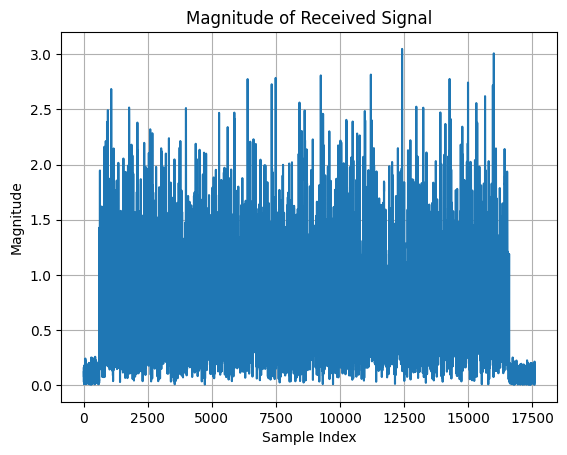

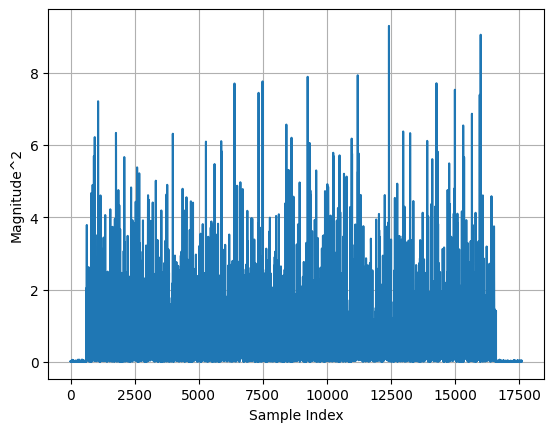

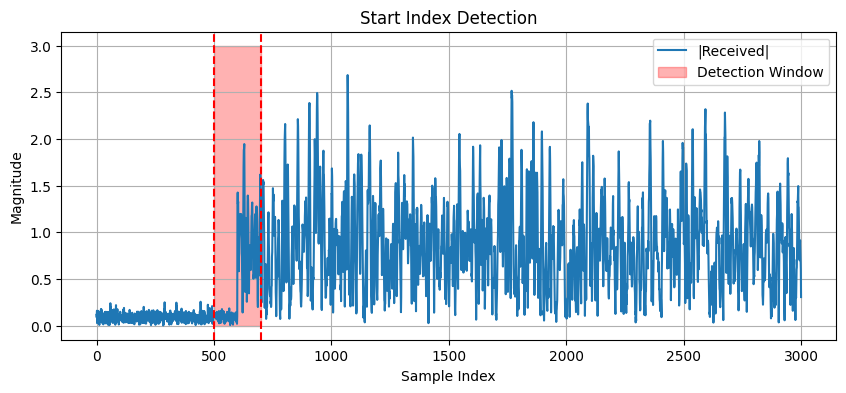

Start Index of Signal: 600


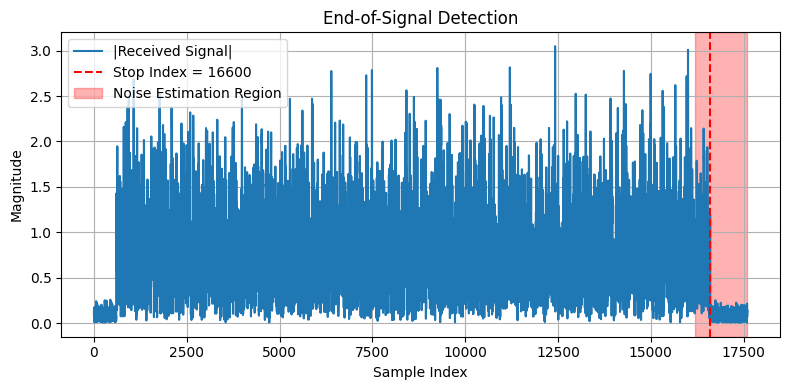

Stop Index: 16600


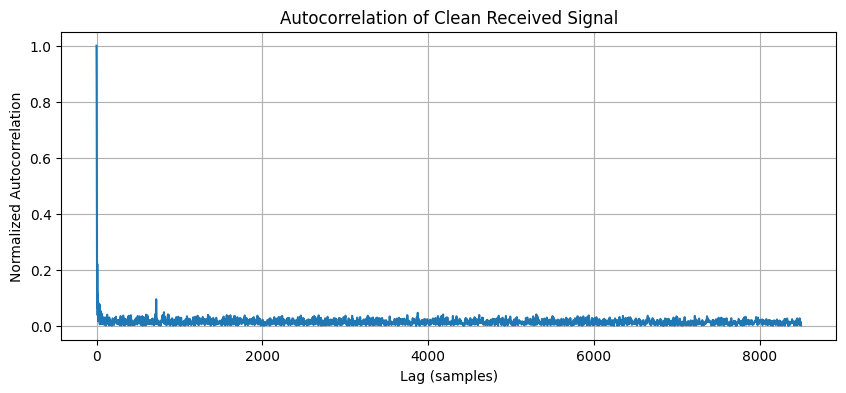

Detected peak lags: [  9 720]
Estimated Symbol Duration: 720 samples


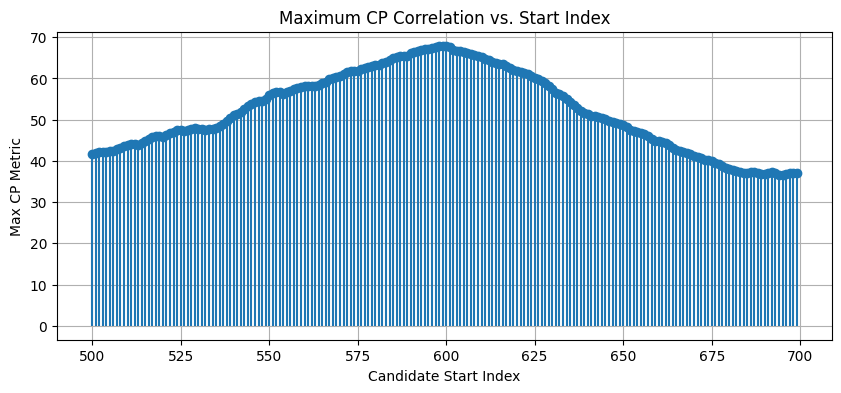

Maximum CP Metric = 67.93 at index = 599


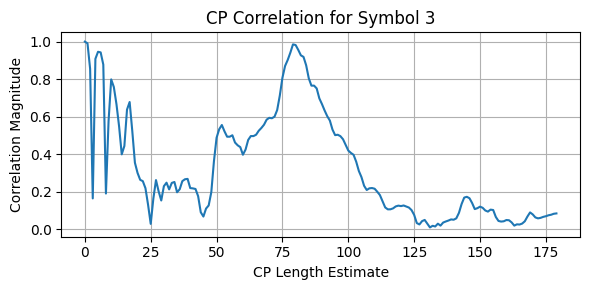

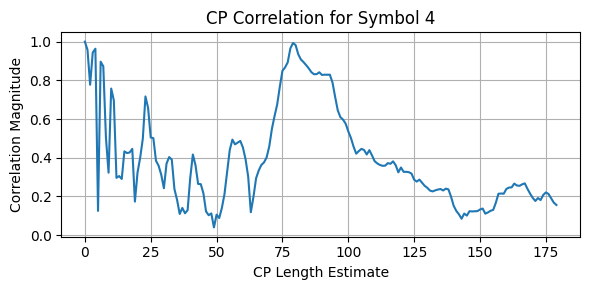

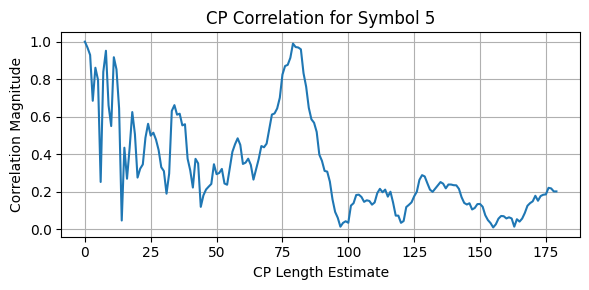

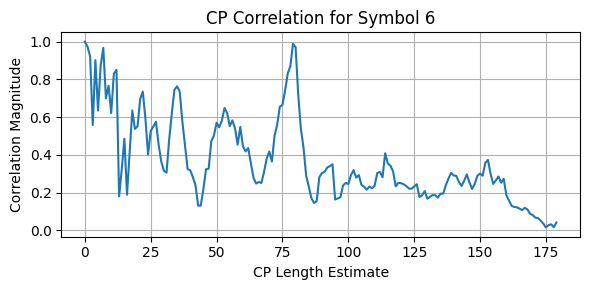

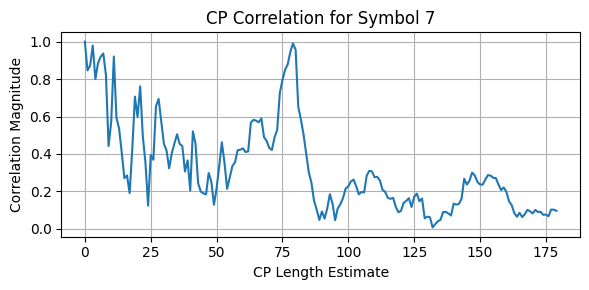

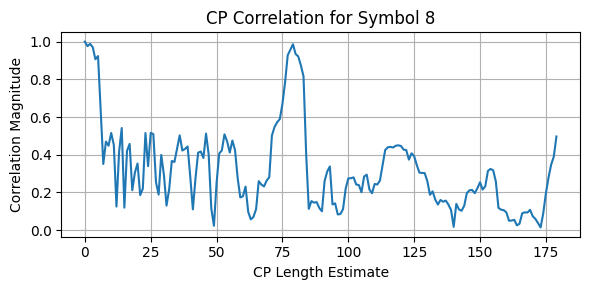

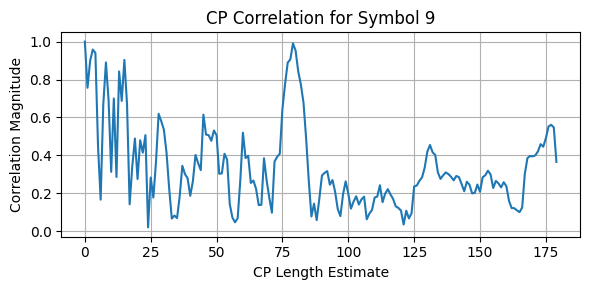

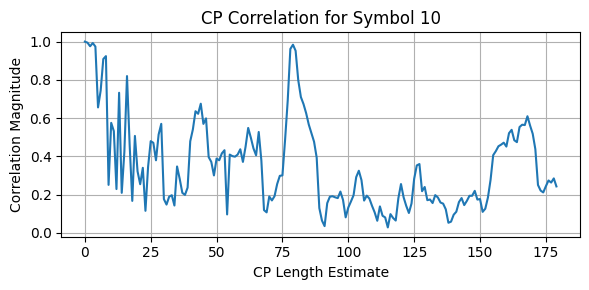

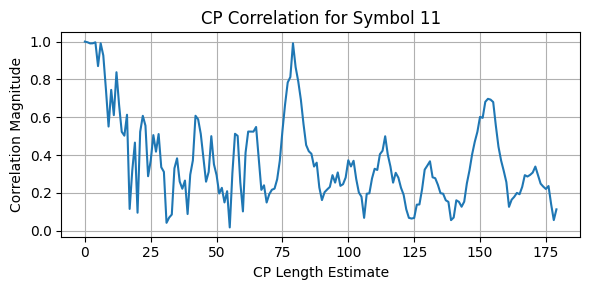

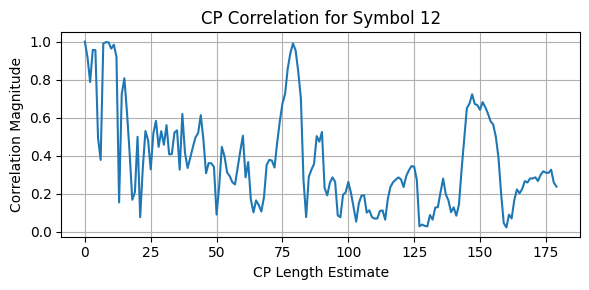

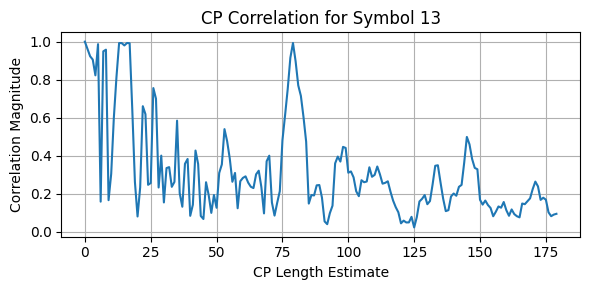

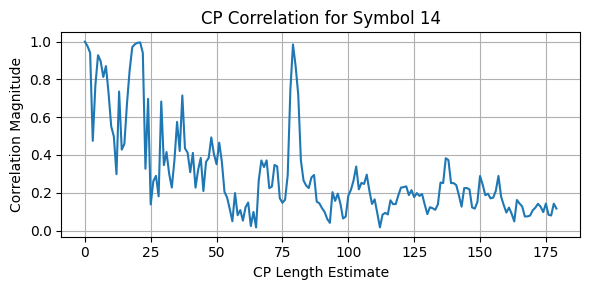

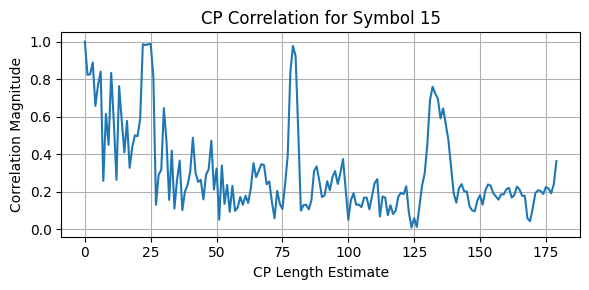

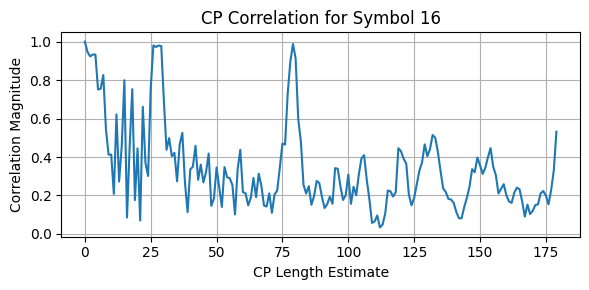

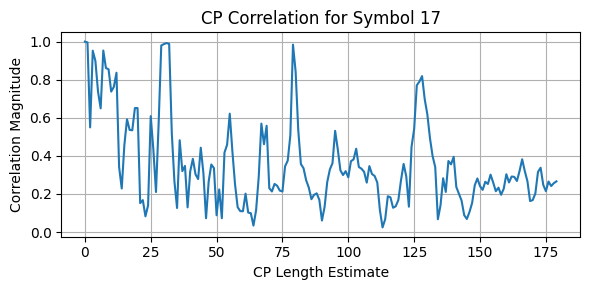

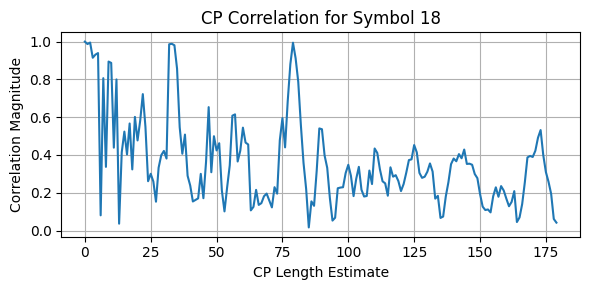

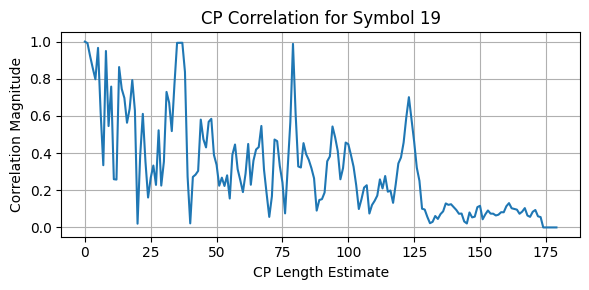

Max averaged CP correlation: 0.8947
Estimated CP Length: 80 samples
Edtimated Symbol Length, Ld:  640
Estimated Symbol Length + CP, Td:  720
Processing for k = 1
  Lcp = 80, Ld = 720, Ls = 800
 num_symbols = 20
  Start index = 600


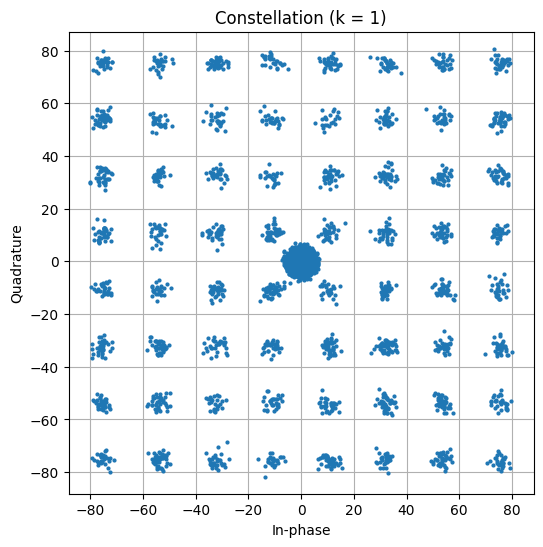


Processing with k=1, Lcp=80, Ld=720, Ls=800
 num_symbols = 20
  Processing start index: 599


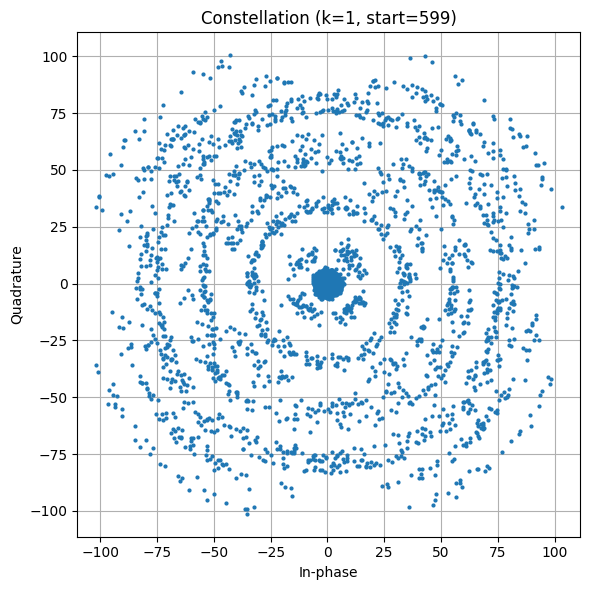

  Processing start index: 600


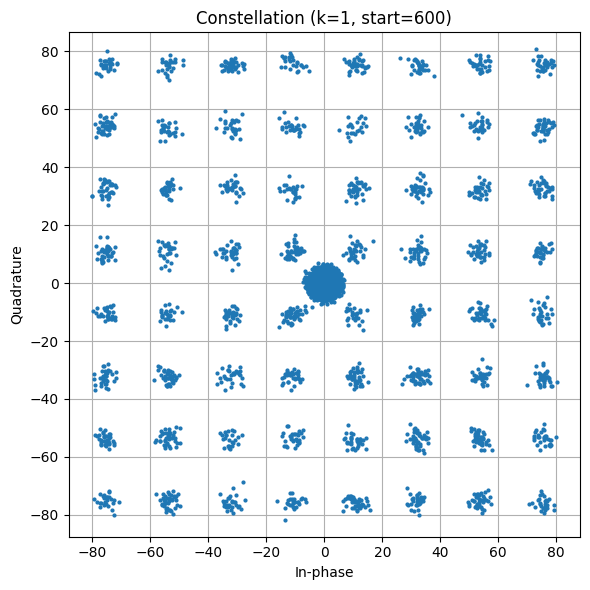

  Processing start index: 601


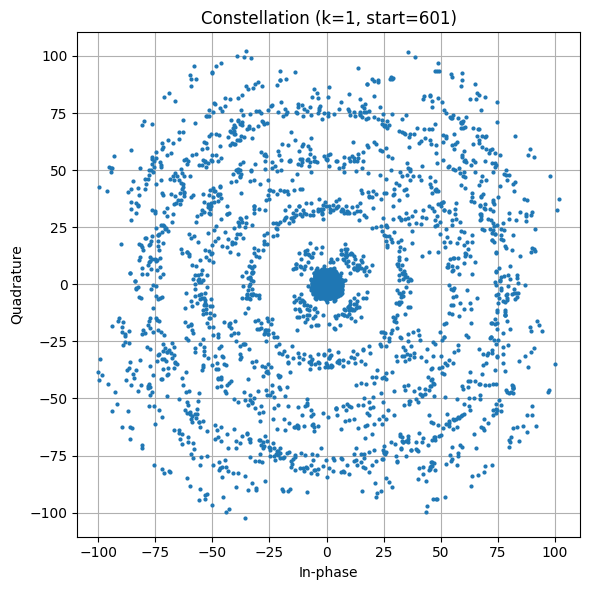

  Processing start index: 602


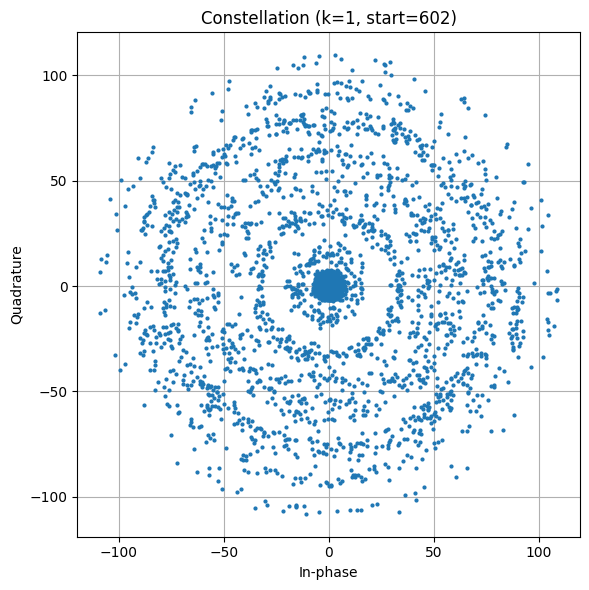


Processing with k=1, Lcp=80, Ld=720, Ls=800


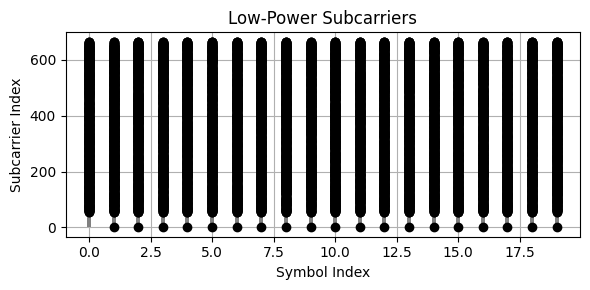

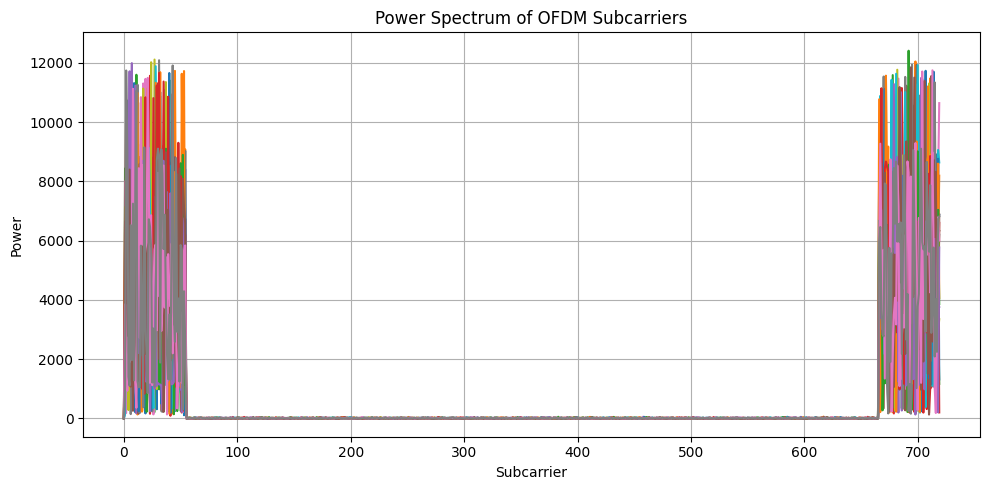

In [116]:
initial_start = 700
threshold_start = 0.7 # the threshold factor is empirically chosen
noise_est_start = 16200
threshold_end = 1
height = 0.05

ofdm_rx = OFDM_RX(rx_signal)
start_index = ofdm_rx.signal_preprocessing(initial_start,threshold_start)
stop_index = ofdm_rx.detect_end_index(noise_est_start, threshold_end, plot=True)
symbol_duration_est = ofdm_rx.autocorrelation(start_index,height)
estimated_cp_length = ofdm_rx.CP_detection(start_index,symbol_duration_est)
ofdm_rx.constellation(estimated_cp_length,symbol_duration_est,start_index,stop_index)
ofdm_rx.constellation_vs_start_index(start_index,symbol_duration_est,estimated_cp_length)
ofdm_rx.PSD_RX(symbol_duration_est,estimated_cp_length,start_index)
